# Вариант 1. Очистка данных и обучение моделей.
Данный вариант предполагает фокусировку на обучении нескольких видов моделей обучения с учителем. В зависимости от набора данных, может предполагаться задача классификации и регрессии. Необходимо после минимальной подготовки датасета к обучению обучить несколько моделей и сравнить их эффективность.

Контекст

Исходный набор данных содержит 1000 записей с 20 категориальными/символьными атрибутами, подготовленными проф. Хофманн. В этом наборе данных каждая запись представляет человека, который берет кредит в банке. Каждый человек классифицируется как подверженный хорошему или плохому кредитному риску в соответствии с набором атрибутов. Ссылку на исходный набор данных можно найти ниже.

Содержание

Практически невозможно разобраться в исходном наборе данных из-за его сложной системы категорий и символов. Таким образом, я написал небольшой скрипт на Python, чтобы преобразовать его в читаемый CSV-файл. Несколько столбцов просто игнорируются, потому что, на мой взгляд, либо они не важны, либо их описания неясны. Выбранными атрибутами являются:

Возраст (числовой)

Пол (текст: мужчина, женщина)

Работа (числовая: 0 - неквалифицированный и нерезидент, 1 - неквалифицированный и резидент, 2 - квалифицированный, 3 - высококвалифицированный)

Жилье (текст: собственное, арендуемое или бесплатное)

Сохранение учетных записей (текст - маленький, умеренный, довольно насыщенный, насыщенно-насыщенный)

Расчетный счет (числовой, в немецких марках)

Сумма кредита (числовая, в немецких марках)

Продолжительность (числовая, в месяце)

Назначение (текст: автомобиль, мебель/оборудование, радио/телевизор, бытовая техника, ремонт, образование, бизнес, отпуск/другое)

In [ ]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [ ]:
dataset = pd.read_csv('german_credit_data.csv')
dataset

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [ ]:
dataset.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [ ]:
dataset.describe(include='O')

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
count,1000,1000,817,606,1000,1000
unique,2,3,4,3,8,2
top,male,own,little,little,car,good
freq,690,713,603,274,337,700


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


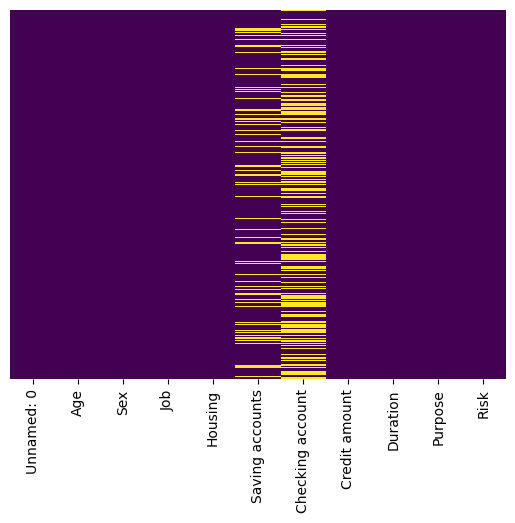

In [ ]:
sns.heatmap(dataset.isnull(), yticklabels=False, cbar=False, cmap='viridis');

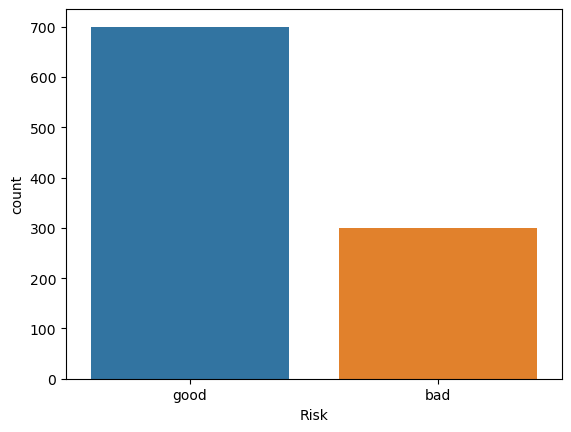

In [ ]:
sns.countplot(x='Risk', data=dataset);

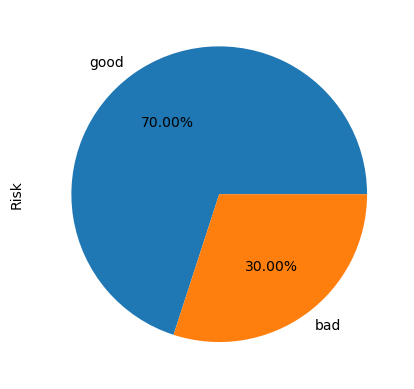

In [ ]:
dataset['Risk'].value_counts().plot(kind='pie',autopct='%.2f%%');

In [ ]:
for col in dataset.columns:
    dataset[col].fillna(dataset[col].mode()[0], inplace=True)

In [ ]:
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,little,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,little,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,little,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [ ]:
label_encoder = LabelEncoder()
dataset['Sex'] = label_encoder.fit_transform(dataset['Sex'])
dataset['Housing'] = label_encoder.fit_transform(dataset['Housing'])
dataset['Saving accounts'] = label_encoder.fit_transform(dataset['Saving accounts'])
dataset['Checking account'] = label_encoder.fit_transform(dataset['Checking account'])
dataset['Purpose'] = label_encoder.fit_transform(dataset['Purpose'])
dataset['Risk'] = label_encoder.fit_transform(dataset['Risk'])
dataset

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,0,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0
...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,1,0,0,1736,12,4,1
996,40,1,3,1,0,0,3857,30,1,1
997,38,1,2,1,0,0,804,12,5,1
998,23,1,2,0,0,0,1845,45,5,0


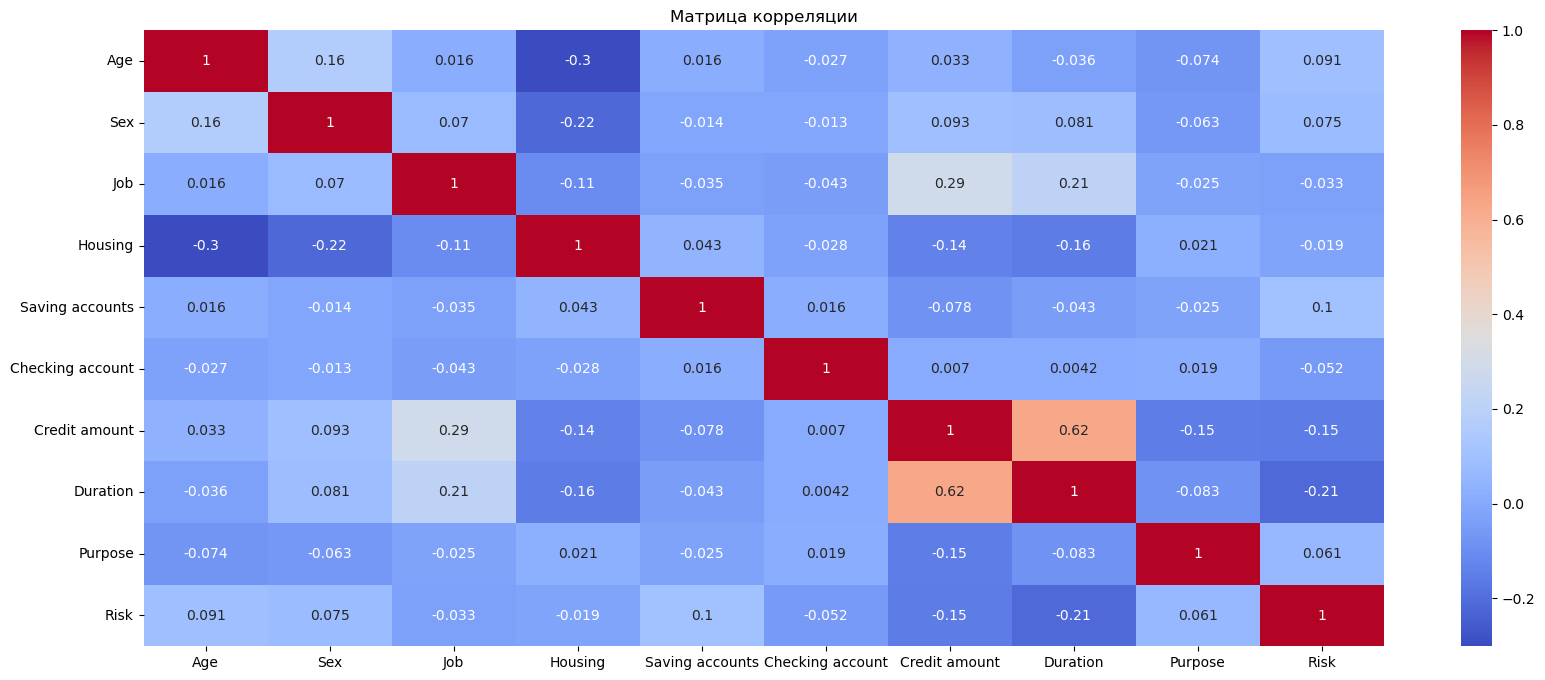

In [ ]:
correlation_matrix = dataset.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

In [ ]:
X = dataset.drop('Risk', axis=1)
y = dataset['Risk']
kf = KFold(n_splits=5,shuffle=True, random_state=15)
def train_run_models_kf(X, y):
    metrics = {
        'Accuracy': make_scorer(accuracy_score),
        'Precision': make_scorer(precision_score, average='weighted'),
        'Recall': make_scorer(recall_score, average='weighted'),
        'F1-Score': make_scorer(f1_score, average='weighted'),
        'ROC AUC': make_scorer(roc_auc_score)
    }

    models = [
        ('Логистическая регрессия', LogisticRegression()),
        ('Метод опорных векторов: c Гауссовым ядром', SVC(kernel='rbf')),
        ('С полиноминальным ядром', SVC(kernel='poly')),
        ('Метод ближайших соседей (9)', KNeighborsClassifier(n_neighbors=9)),
        ('Многослойный перцептрон', MLPClassifier()),
        ('Дерево решений (9)', DecisionTreeClassifier(max_depth=9)),
        ('Наивный байесовский классификатор', GaussianNB()),
        ('Градиентный бустинг', GradientBoostingClassifier()),
        ('Случайный лес', RandomForestClassifier())
    ]

    acc_dict = {}
    for name, model in models:
        model_scores = {}
        for metric_name, scorer in metrics.items():
            cv_results = cross_val_score(model, X, y, cv=kf, scoring=scorer, n_jobs=-1)
            model_scores[metric_name] = cv_results.mean()

        acc_dict[name] = model_scores

    acc_df = pd.DataFrame.from_dict(acc_dict, orient='index')
    display(acc_df)

train_run_models_kf(X, y)

,Accuracy,Precision,Recall,F1-Score,ROC AUC
Логистическая регрессия,0.710,0.682296,0.710,0.643816,0.548961
Метод опорных векторов: c Гауссовым ядром,0.707,0.690346,0.707,0.611493,0.522690
С полиноминальным ядром,0.706,0.646916,0.706,0.595044,0.512071
Метод ближайших соседей (9),0.684,0.636547,0.684,0.635871,0.539721
Многослойный перцептрон,0.641,0.576201,0.568,0.546166,0.534193
Дерево решений (9),0.658,0.636554,0.656,0.646210,0.564653
Наивный байесовский классификатор,0.697,0.664905,0.697,0.667413,0.575506
Градиентный бустинг,0.700,0.669041,0.701,0.657800,0.565013
Случайный лес,0.697,0.676050,0.699,0.670875,0.573313


In [ ]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=15)
def train_run_models_skf(X, y):
    metrics = {
        'Accuracy': make_scorer(accuracy_score),
        'Precision': make_scorer(precision_score, average='weighted'),
        'Recall': make_scorer(recall_score, average='weighted'),
        'F1-Score': make_scorer(f1_score, average='weighted'),
        'ROC AUC': make_scorer(roc_auc_score)
    }

    models = [
        ('Логистическая регрессия', LogisticRegression()),
        ('Метод опорных векторов: c Гауссовым ядром', SVC(kernel='rbf')),
        ('С полиноминальным ядром', SVC(kernel='poly')),
        ('Метод ближайших соседей (9)', KNeighborsClassifier(n_neighbors=9)),
        ('Многослойный перцептрон', MLPClassifier()),
        ('Дерево решений (9)', DecisionTreeClassifier(max_depth=9)),
        ('Наивный байесовский классификатор', GaussianNB()),
        ('Градиентный бустинг', GradientBoostingClassifier()),
        ('Случайный лес', RandomForestClassifier())
    ]

    acc_dict = {}
    for name, model in models:
        model_scores = {}
        for metric_name, scorer in metrics.items():
            cv_results = cross_val_score(model, X, y, cv=skf, scoring=scorer, n_jobs=-1)
            model_scores[metric_name] = cv_results.mean()

        acc_dict[name] = model_scores

    acc_df = pd.DataFrame.from_dict(acc_dict, orient='index')
    display(acc_df)

train_run_models_skf(X, y)

,Accuracy,Precision,Recall,F1-Score,ROC AUC
Логистическая регрессия,0.708,0.673838,0.708,0.637558,0.543810
Метод опорных векторов: c Гауссовым ядром,0.705,0.702986,0.705,0.607117,0.519762
С полиноминальным ядром,0.702,0.642997,0.702,0.592973,0.510000
Метод ближайших соседей (9),0.680,0.629087,0.680,0.631771,0.536190
Многослойный перцептрон,0.618,0.611555,0.700,0.523677,0.518810
Дерево решений (9),0.669,0.637179,0.671,0.649257,0.554286
Наивный байесовский классификатор,0.698,0.666170,0.698,0.667627,0.577619
Градиентный бустинг,0.704,0.660766,0.702,0.660300,0.570000
Случайный лес,0.710,0.677110,0.693,0.684027,0.582381


# Попробуем сбалансировать классы

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

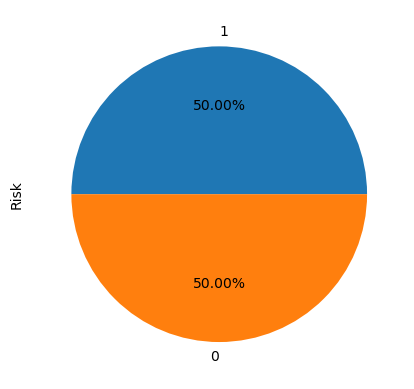

In [ ]:
y.value_counts().plot(kind='pie',autopct='%.2f%%');

In [ ]:
X

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,0,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5
2,49,1,1,1,0,0,2096,12,3
3,45,1,2,0,0,0,7882,42,4
4,53,1,2,0,0,0,4870,24,1
...,...,...,...,...,...,...,...,...,...
1395,67,0,3,0,0,0,14895,6,1
1396,25,0,2,0,0,0,1428,14,1
1397,45,0,2,0,0,1,12591,28,1
1398,34,1,1,1,0,1,1921,17,4


In [ ]:
train_run_models_kf(X, y)

,Accuracy,Precision,Recall,F1-Score,ROC AUC
Логистическая регрессия,0.655000,0.658587,0.655000,0.654811,0.654989
Метод опорных векторов: c Гауссовым ядром,0.555000,0.580450,0.555000,0.522817,0.557534
С полиноминальным ядром,0.527143,0.630696,0.527143,0.413345,0.527237
Метод ближайших соседей (9),0.632857,0.637617,0.632857,0.631580,0.632479
Многослойный перцептрон,0.530714,0.634924,0.492143,0.426758,0.580864
Дерево решений (9),0.689286,0.696187,0.692143,0.692244,0.692131
Наивный байесовский классификатор,0.676429,0.683897,0.676429,0.675012,0.677798
Градиентный бустинг,0.742857,0.747171,0.742857,0.743134,0.744153
Случайный лес,0.749286,0.748065,0.749286,0.749513,0.756628


# Функция важности признаков

In [ ]:
def plot_feature_importance(model, feature_names):
    feature_importance = model.feature_importances_

    # Сортировка признаков по их важности
    sorted_indices = feature_importance.argsort()
    sorted_feature_importance = feature_importance[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_names)), sorted_feature_importance, align='center')
    plt.yticks(range(len(feature_names)), sorted_feature_names)
    plt.show()

In [ ]:
X

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,0,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5
2,49,1,1,1,0,0,2096,12,3
3,45,1,2,0,0,0,7882,42,4
4,53,1,2,0,0,0,4870,24,1
...,...,...,...,...,...,...,...,...,...
1395,67,0,3,0,0,0,14895,6,1
1396,25,0,2,0,0,0,1428,14,1
1397,45,0,2,0,0,1,12591,28,1
1398,34,1,1,1,0,1,1921,17,4


In [ ]:
model_gb = GradientBoostingClassifier()
model_gb.fit(X, y)

GradientBoostingClassifier()

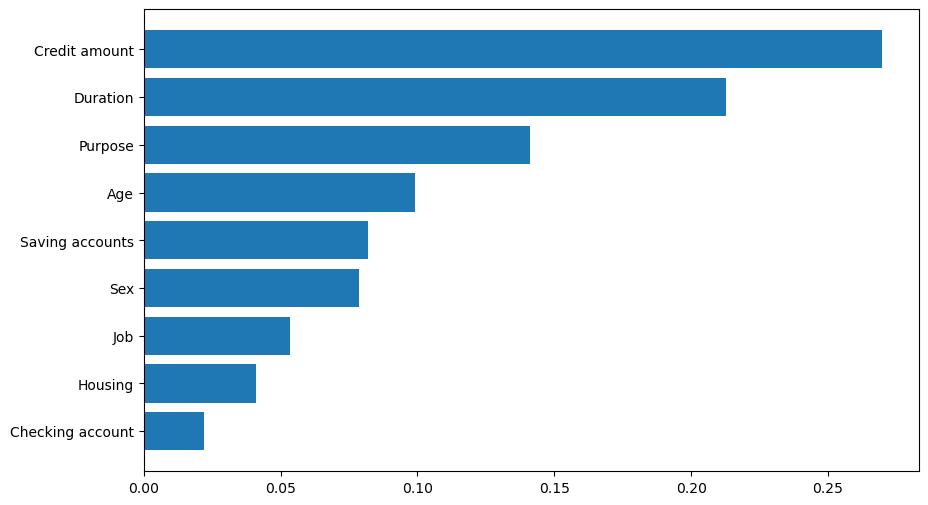

In [ ]:
plot_feature_importance(model_gb, X.columns)

In [ ]:
X = X.drop(['Checking account', 'Job', 'Housing'], axis=1)
X

,Age,Sex,Saving accounts,Credit amount,Duration,Purpose
0,67,1,0,1169,6,5
1,22,0,0,5951,48,5
2,49,1,0,2096,12,3
3,45,1,0,7882,42,4
4,53,1,0,4870,24,1
...,...,...,...,...,...,...
1395,67,0,0,14895,6,1
1396,25,0,0,1428,14,1
1397,45,0,0,12591,28,1
1398,34,1,0,1921,17,4


In [ ]:
y

0       1
1       0
2       1
3       1
4       0
       ..
1395    0
1396    0
1397    0
1398    0
1399    0
Name: Risk, Length: 1400, dtype: int32

In [ ]:
train_run_models_kf(X, y)

,Accuracy,Precision,Recall,F1-Score,ROC AUC
Логистическая регрессия,0.647857,0.652434,0.647857,0.648232,0.649607
Метод опорных векторов: c Гауссовым ядром,0.554286,0.579086,0.554286,0.522245,0.556783
С полиноминальным ядром,0.527143,0.630696,0.527143,0.413345,0.527237
Метод ближайших соседей (9),0.631429,0.636153,0.631429,0.630082,0.630948
Многослойный перцептрон,0.552857,0.477983,0.573571,0.562743,0.552208
Дерево решений (9),0.687143,0.684481,0.682143,0.685797,0.681037
Наивный байесовский классификатор,0.662857,0.668095,0.662857,0.662119,0.663497
Градиентный бустинг,0.737143,0.740487,0.737143,0.737532,0.737925
Случайный лес,0.737143,0.733943,0.736429,0.733780,0.735350


<AxesSubplot:>

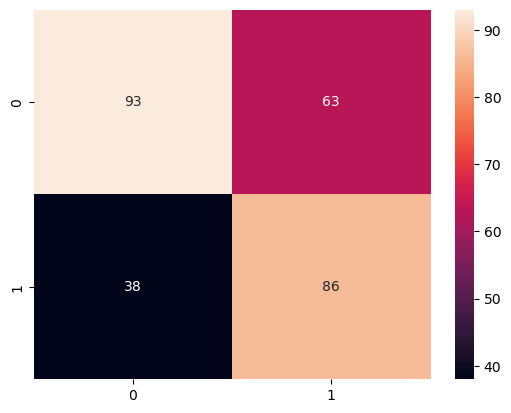

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)
model_1 = LogisticRegression(max_iter=11000)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

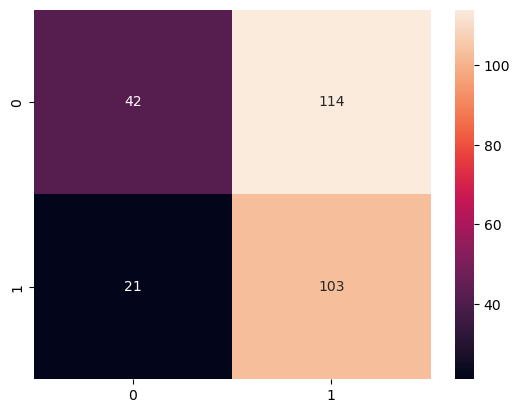

In [ ]:
model_2 = SVC(kernel='rbf')
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

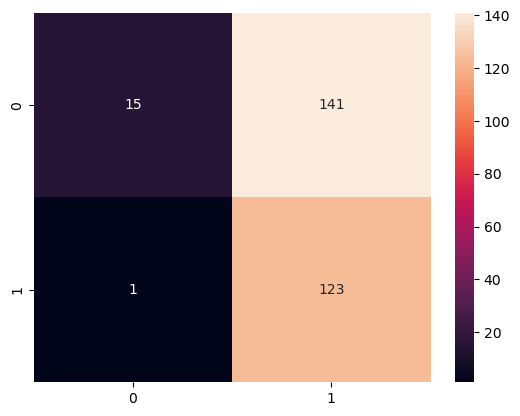

In [ ]:
model_3 = SVC(kernel='poly')
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

C:\Users\user\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<AxesSubplot:>

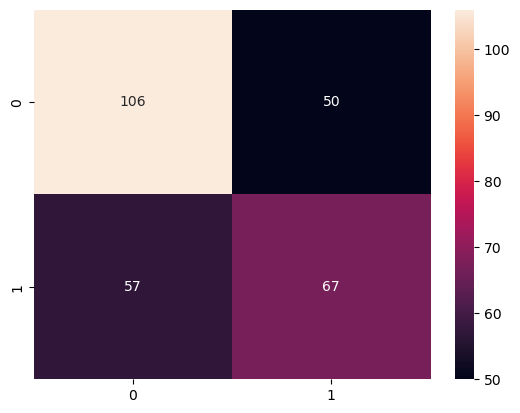

In [ ]:
model_4 = KNeighborsClassifier(n_neighbors=9)
model_4.fit(X_train, y_train)
y_pred = model_4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

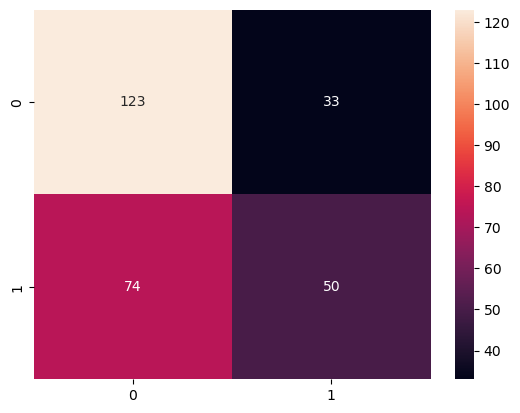

In [ ]:
model_5 = MLPClassifier()
model_5.fit(X_train, y_train)
y_pred = model_5.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

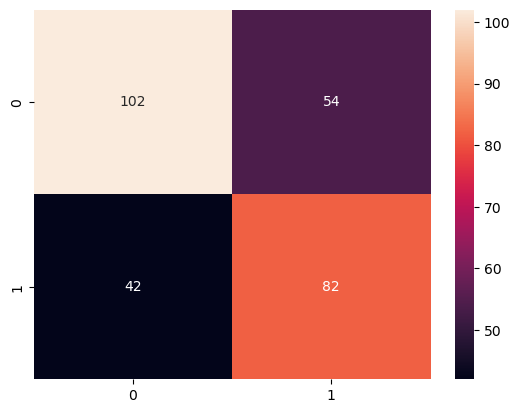

In [ ]:
model_6 = DecisionTreeClassifier(max_depth=9)
model_6.fit(X_train, y_train)
y_pred = model_6.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

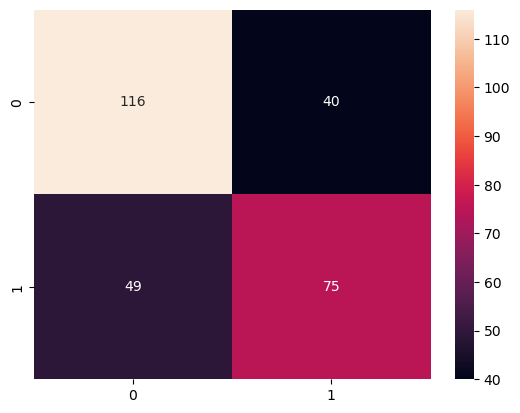

In [ ]:
model_7 =  GaussianNB()
model_7.fit(X_train, y_train)
y_pred = model_7.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

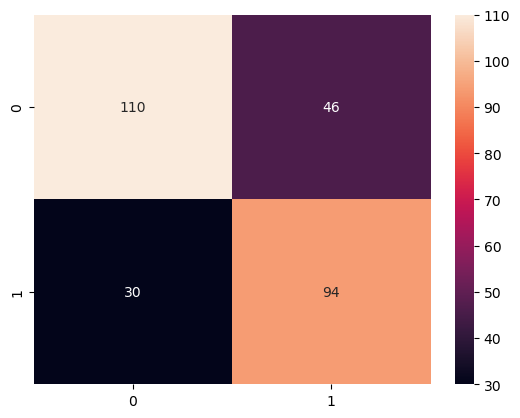

In [ ]:
model_8 = GradientBoostingClassifier()
model_8.fit(X_train, y_train)
y_pred = model_8.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

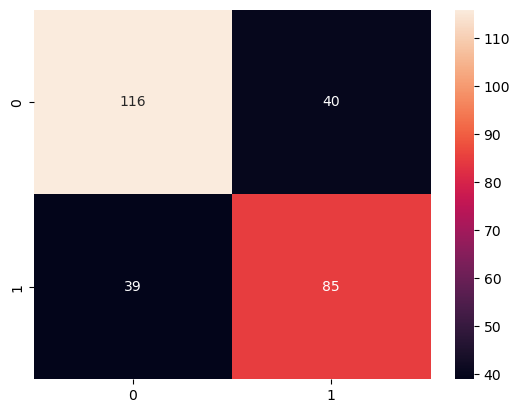

In [ ]:
model_9 =  RandomForestClassifier()
model_9.fit(X_train, y_train)
y_pred = model_9.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')